# Chapter 1: The contrast-dependence of spatial frequency tuning
Here, we'll organize (better than has been organized in the predecesor notebooks [descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]) the analysis for chapter 1 of my thesis.

Last access (y.m.d): 21.10.20  
Last update (y.m.d): 21.10.20  

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Tuning shifts as scatter plots, ratios (hist) **(1)**
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
- Trajectories of tuning metrics across contrasts  **(2)**

## Initialize

In [984]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

In [1067]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

In [1068]:
whichArea = 'LGN'; # 'LGN' or 'V1'
wMods = 1 if whichArea == 'V1' else 0; # if wMods 
wModStr = '_wMods' if wMods else ''

toGroup = 'simple' if whichArea == 'V1' else 'triType'; # triType is 'magno', 'parvo', 'other'

fitBase = '210914'; # descriptive fits (rvc,SF tuning)
#fitBase = '210503'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

if whichArea == 'LGN':
    thresh = 60;
#     suffix = '%s%s_211019_vT00_dvT00' % (whichArea, wModStr)
    suffix = '%s%s_211020_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
else:
    thresh = 70;
    suffix = '%s%s_210921_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
# suffix = '%s%s_210826_vT60_dvT60' % (whichArea, wModStr)

# suffix = 'V1_wMods_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);


saveName = 'figures/reports/ch1/%s/' % (suffix) # for one save name for all figures
save_loc = base_dir + saveName;

#### Trim the jointList on some criteria?

In [1069]:
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > VarExplThresh) 
# altA: single grating tuning curve at high contrast must have non-nan varExpl (i.e. > varExplThresh) 
# --- for the diff-of-gauss tuning fit

# Get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

prevCells = len(jointList)
critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]
# critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]


jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 20 cells (17.39% of the original 115)


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Now, put this list of dictionaries into a pandas dataframe for better plotting (hacky)

- First, create a pandas data frame
- Then, json "normalize" each top-level dictionary (e.g. metadata) into it's own dataframe
- Finally, combine _those_ dataframes into one

In [1070]:
ohno = pd.DataFrame.from_dict(jointList) #, orient='index')

meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
# supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

mega = pd.concat((meta, metr, modl, basc), axis=1)

In [1071]:
colors = [];

# classify as simple or complex [FOR USE WITH V1]
simple = mega['f1f0_ratio'] > 1
msk = np.copy(simple)
simple[~msk] = 'complex'
simple[msk] = 'simple'
mega['simple'] = simple

if whichArea == 'LGN':
    cellTypes = mega['cellType'];
    non_mp = np.logical_and(~(cellTypes=='parvo'), ~(cellTypes=='magno'))
    cellTypes[non_mp] = 'other'
    
    mega['triType'] = cellTypes;
    
# get color scheme
cnt = 0;
grp_names = [];
for nm, group in mega.groupby(toGroup):
    cnt += 1;
    grp_names.append(nm)
    
# colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
colors = sns.color_palette('colorblind', n_colors=cnt-1)
colors.append((0,0,0)); # add black!

alph= 0.8/cnt
alphHist = 1; # the bins are non-overlapping now, so no need for transparency

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


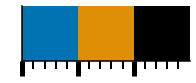

In [1072]:
sns.palplot(colors)

## 00. Set any overall parameters
For example, are we getting descr fits or DoG fits?

In [1073]:
isDog = 1; # 0 if descr; 1 if DoG
dog_suffix = 'dog_' if isDog else '';
dog_suffix_sv = '_dog' if isDog else '';
dog_suffix_plt = 'dog ' if isDog else ''

## 0. Distribution of tuning measures


In [1074]:
com, _ = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0, valIsFrac=True)
var, _ = hf.jl_get_metric_byCon(jointList, 'sfVar', conVal=1.0, disp=0, valIsFrac=True)

pSf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
pSf_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_stdLog' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
# sf70
sf70, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
sf70_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conVal=1.0,
                                        disp=0, valIsFrac=True)
sf70_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
sf70_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# charFreq
cFreq, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=1.0, disp=0, valIsFrac=True)
cFreq_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conVal=1.0,
                                        disp=0, valIsFrac=True)
cFreq_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
cFreq_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# bwHalf
bwHalf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_std, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_std' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=0.33, disp=0, 
                                         valIsFrac=True, conTol=0.065)

mega['com_h'] = com
mega['var_h'] = com

mega['pSf_mn'] = pSf
mega['pSf_stdLog'] = pSf_stdLog
mega['sf70_mn'] = sf70
mega['sf70_stdLog'] = sf70_stdLog
mega['sf70_mn_third'] = sf70_third
mega['sf70_stdLog_third'] = sf70_stdLog_third
mega['charFreq_mn'] = cFreq
mega['charFreq_stdLog'] = cFreq_stdLog
mega['charFreq_mn_third'] = cFreq_third
mega['charFreq_stdLog_third'] = cFreq_stdLog_third
mega['bwHalf_mn'] = bwHalf
mega['bwHalf_std'] = bwHalf_std
mega['bwHalf_mn_third'] = bwHalf_third

if whichArea == 'LGN':
    mega['conGain_max'] = np.array([np.nanmax(mega['conGain'][x][0]) for x in mega['conGain'].keys()])

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: All-NaN slice encountered


In [1075]:
# simple lin. regression
def fn(B, x):
    return B[0]*x + B[1]
linear = odrpack.Model(fn)

In [1076]:
highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % dog_suffix, 0, 1)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:3612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


##### Show that pSf and sf70 are correlated

Beta: [0.83429947 0.3740377 ]
Beta Std Error: [0.06262085 0.03206831]
Beta Covariance: [[1.15434285e-04 2.97622568e-05]
 [2.97622568e-05 3.02725534e-05]]
Residual Variance: 33.97058739230257
Inverse Condition #: 0.42314742011830375
Reason(s) for Halting:
  Sum of squares convergence


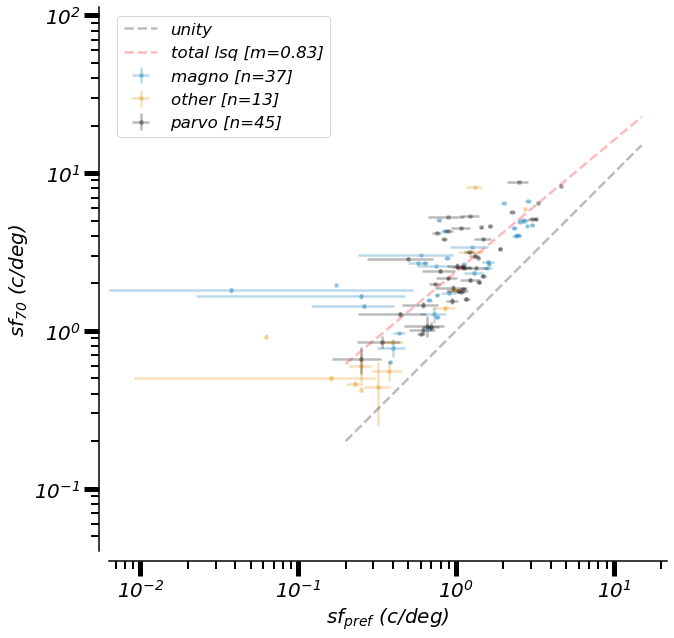

In [1077]:
saveName = '00_00_pSf_sf70_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['sf70_mn']));
    plt.errorbar(group['pSf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Plot distribution of sf70 at highContrast

In [1078]:
sf70bins = np.linspace(-2, 4, 13)

In [1079]:
def bin_offsets(nBins, width):
    if np.mod(nBins,2) == 0: # i.e. even # of bins
        return width*np.linspace(-0.5-(nBins/2-1), 0.5+(nBins/2-1), nBins)
    else: # i.e. odd # of bins
        return width*np.linspace(-np.floor(nBins/2), np.floor(nBins/2), nBins)

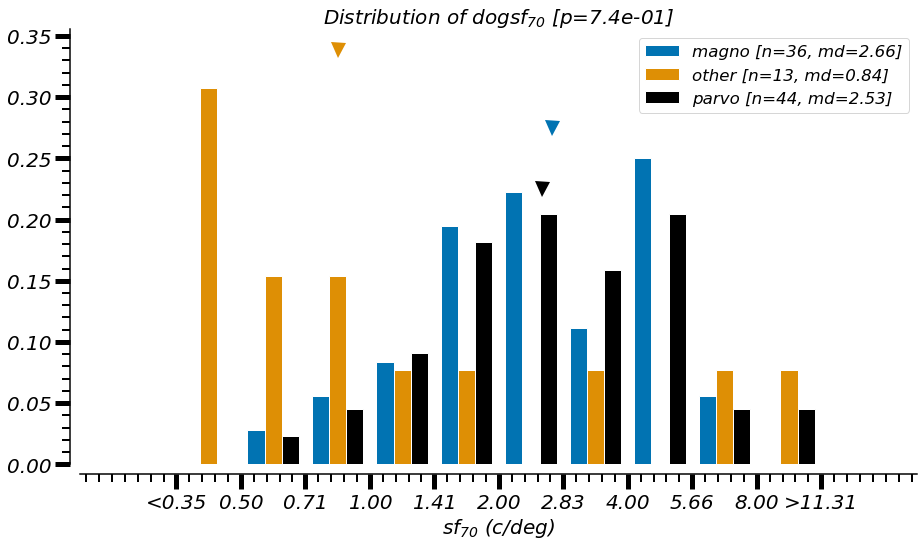

In [1080]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_01_sf70%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['sf70_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['sf70_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    
plt.xlabel(r'$sf_{70}$ (c/deg)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $%ssf_{70}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


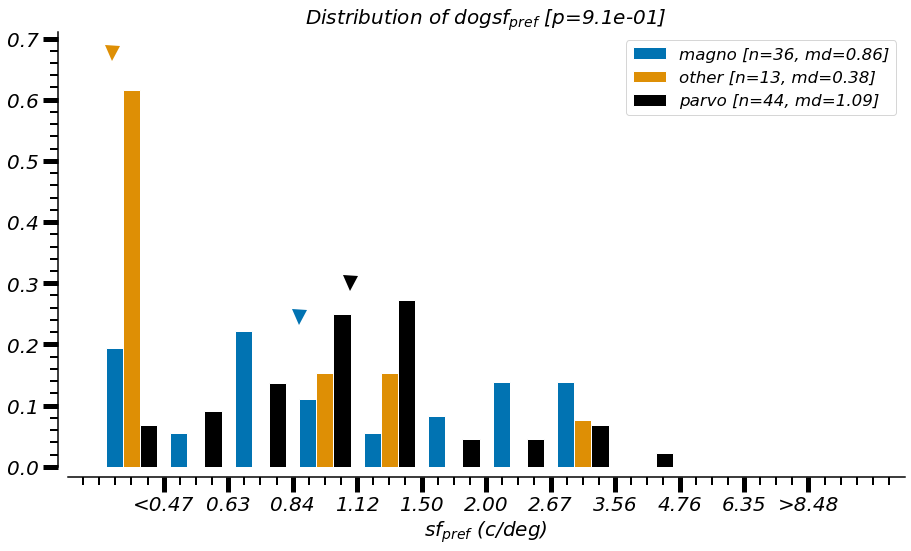

In [1081]:
saveName = '00_01alt_pSf_highCon%s.pdf' % dog_suffix_sv

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['pSf_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['pSf_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    else:
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    
ttest = ss.ttest_ind(*to_comp);
plt.xlabel(r'$sf_{pref}$ (c/deg)');
plt.title(r'Distribution of $%ssf_{pref}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


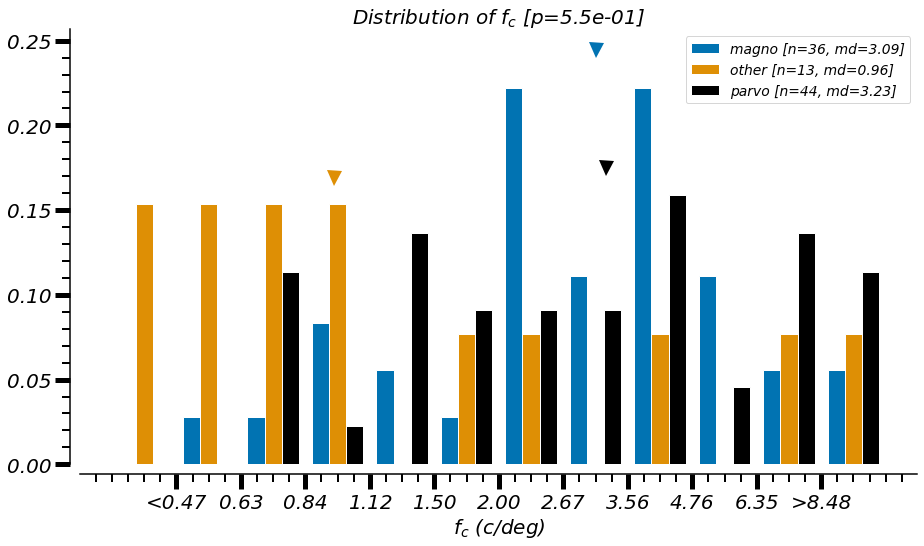

In [1082]:
saveName = '00_01alt_charFreq.pdf'

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['charFreq_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['charFreq_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['charFreq_mn']))
    else:
        to_comp.append(hf.nan_rm(group['charFreq_mn']))
    
ttest = ss.ttest_ind(*to_comp);
plt.xlabel(r'$f_c$ (c/deg)');
plt.title(r'Distribution of $f_c$ [p=%.1e]' % (ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='x-small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Max. con gain (if LGN, only)

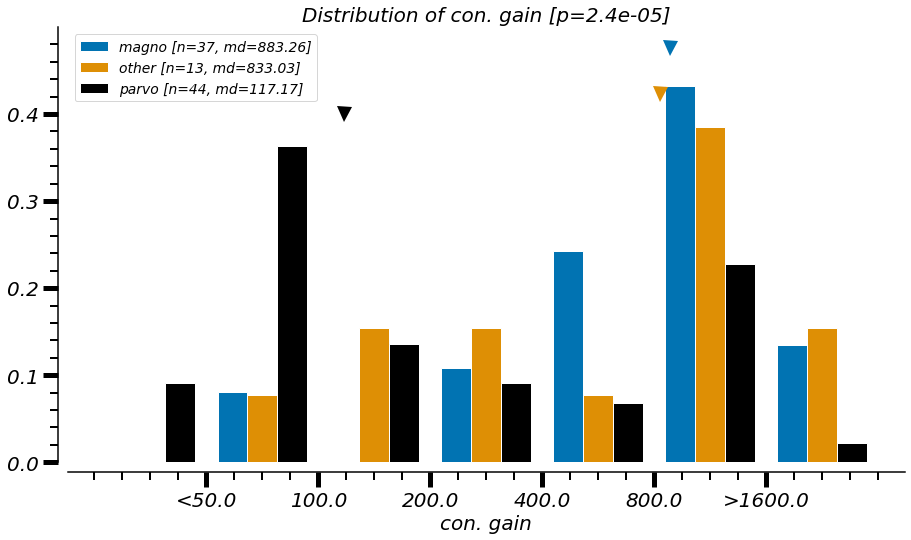

In [1083]:
if whichArea == 'LGN':
    
    nBins = 8
    conGain_bins = np.log10(np.geomspace(25, 25*np.power(2, nBins-1), nBins));
    
    saveName = '00_01alt_conGain.pdf'

    plt.figure(figsize=(15, 8));

    grouped = mega.groupby(toGroup)

    # gather and calculate
    bins = conGain_bins
    stepSize = (bins[-1] - bins[0])/(len(bins)-1);
    binPlotLocs = bins[1:] - 0.5*stepSize;
    clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

    tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

    to_comp = [];
    
    width = 0.8*stepSize/cnt;
    offsets = bin_offsets(cnt, width);
    
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
        clipped = [np.clip(np.log10(x), clipLow, clipHigh) for x in hf.nan_rm(group['conGain_max'])];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        # calculate
        # nSF = [len(x) for x in psfs_clipped]
        mdn = np.nanmedian(group['conGain_max']);
        # mnSF = [np.nanmean(x) for x in psfs];
        # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

        plt.plot(np.log10(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)

        plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
                label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
        tickStrs = ['%.1f' % np.power(10, x) for x in tickVals];
        tickStrs[0] = '<%s' % tickStrs[0];
        tickStrs[-1] = '>%s' % tickStrs[-1];
        plt.xticks(tickVals, tickStrs);
        
        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(hf.nan_rm(group['conGain_max']))
        else:
            to_comp.append(hf.nan_rm(group['conGain_max']))

    ttest = ss.ttest_ind(*to_comp);
    plt.xlabel('con. gain');
    plt.title('Distribution of con. gain [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
    plt.legend(fontsize='x-small')

    sns.despine(offset=10);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


##### Plot distribution of bwHalf at highContrast

In [1084]:
bwHalfbins = np.linspace(0, 6, 13);# np.linspace(0, 4, 13)

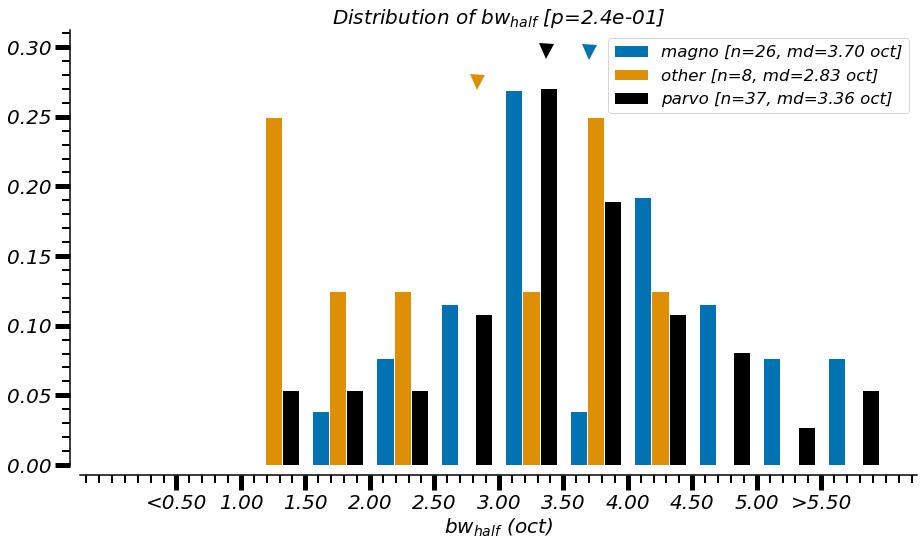

In [1085]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_02_bwHalf%s%s.pdf' % (lbl, dog_suffix_sv)

non_nan = ~np.isnan(pSf);

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = bwHalfbins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['bwHalf_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['bwHalf_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f oct]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))

ttest = ss.ttest_ind(*to_comp);
    
plt.xlabel(r'$bw_{half}$ (oct)');
plt.title(r'Distribution of $bw_{half}$ [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Ask if sf70 and bwHalf are correlated?

Beta: [ 0.22427354 -0.52351605]
Beta Std Error: [0.01833438 0.08480515]
Beta Covariance: [[ 2.92956103e-05 -1.30214768e-04]
 [-1.30214768e-04  6.26779329e-04]]
Residual Variance: 11.474395133732418
Inverse Condition #: 0.05185991322283449
Reason(s) for Halting:
  Sum of squares convergence


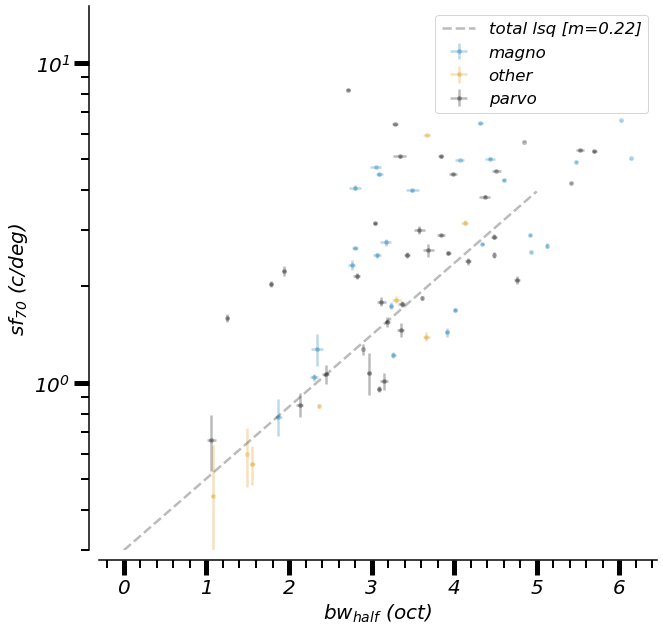

In [1086]:
saveName = '00_03a_bwHalf_sf70%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

sf70[sf70_stdLog==0] = 1e-3
bwHalf_std[bwHalf_std==0] = 1e-3

mydata = odrpack.RealData(bwHalf[non_nan], np.log10(sf70[non_nan]), 
                          sx=bwHalf_std[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(bwHalf[non_nan], np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['bwHalf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)

### Plot unity line, model; set up legend
# plt.xscale('log')
plt.yscale('log')
plt.ylim([3e-1, 1.5e1])
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

xvals = np.linspace(0, 5, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, xvals)), 
         'k--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$bw_{half}$ (oct)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


Beta: [2.60880229 2.71501391]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Beta: [2.39905262 2.66590318]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Beta: [2.57081441 2.3773942 ]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected


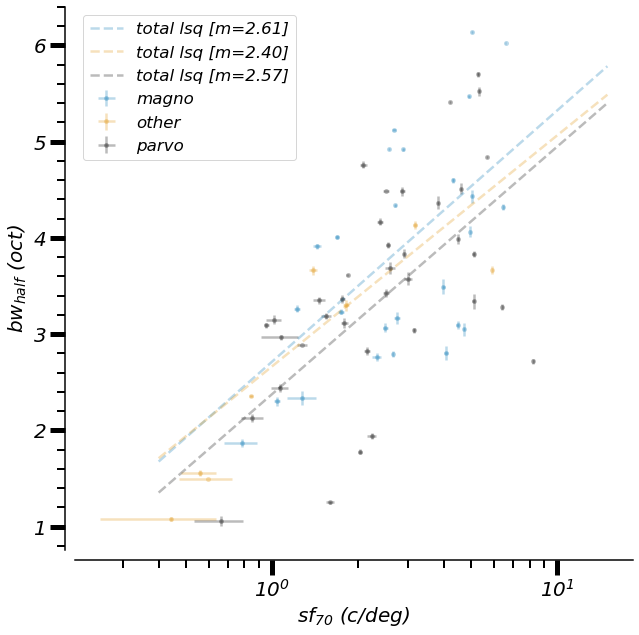

In [1087]:
saveName = '00_03b_sf70_bwHalf%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['sf70_mn'], group['bwHalf_mn'], xerr=group['sf70_stdLog'], yerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['bwHalf_mn']));
    
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], 
                              sy=group['bwHalf_std'][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)), 
             '--', color=clr, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
    

### Plot unity line, model; set up legend
plt.xscale('log')
# plt.yscale('log')
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

plt.legend(fontsize='small')
plt.ylabel(r'$bw_{half}$ (oct)')
plt.xlabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## 1. Shifts with contrast

##### First, let's compute the ratios (and std. of ratios)

In [1088]:
def match_lengths(x):
    # fill with NaN to make sure that all lists in the array have the same length
    max_len = np.max([len(xp) for xp in x])
    for i, xp in enumerate(x):
        if len(xp) < max_len:
            tmp = np.nan * np.zeros((max_len, ));
            tmp[0:len(xp)] = xp
            x[i] = tmp
            
    return np.stack(x)

In [1089]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [1090]:
### First, ratios/diffs at one-third contrast

cf, cf_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%scharFreq_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)
sf70, sf70_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)
bwHalf, bwHalf_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)

cf = match_lengths(cf)
cf_third = match_lengths(cf_third)
sf70 = match_lengths(sf70)
sf70_third = match_lengths(sf70_third)
bwHalf = match_lengths(bwHalf)
bwHalf_third = match_lengths(bwHalf_third)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

        
    cf_rats = np.divide(np.nanmean(np.log2(np.divide(cf, cf_third)), axis=1), conRat)
    cf_rats_std = np.divide(np.nanstd(np.log2(np.divide(cf, cf_third)), axis=1), conRat)
    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)

    mega['boot_cf_rats_third%s' % lbl] = cf_rats
    mega['boot_cf_rats_std_third%s' % lbl] = cf_rats_std
    mega['boot_sf70_rats_third%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_third%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_third%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_third%s' % lbl] = bwHalf_diffs_std

### Then, ratios/diffs at lowest valid

cf, cf_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_dog_charFreq_values', whichMod=isDog, atLowest=1, returnBothCons=True)
sf70, sf70_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_sf70_values', whichMod=isDog, atLowest=1, returnBothCons=True)
bwHalf, bwHalf_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=1, returnBothCons=True)

cf = match_lengths(cf)
cf_lo = match_lengths(cf_lo)
sf70 = match_lengths(sf70)
sf70_lo = match_lengths(sf70_lo)
bwHalf = match_lengths(bwHalf)
bwHalf_lo = match_lengths(bwHalf_lo)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

    cf_rats = np.divide(np.nanmean(np.log2(np.divide(cf, cf_lo)), axis=1), conRat)
    cf_rats_std = np.divide(np.nanstd(np.log2(np.divide(cf, cf_lo)), axis=1), conRat)
    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)

    mega['boot_cf_rats_lowest%s' % lbl] = cf_rats
    mega['boot_cf_rats_std_lowest%s' % lbl] = cf_rats_std
    mega['boot_sf70_rats_lowest%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_lowest%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_lowest%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_lowest%s' % lbl] = bwHalf_diffs_std

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:3612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


#### 1.01 - $f_c$ across contrast (ratio, as hist)

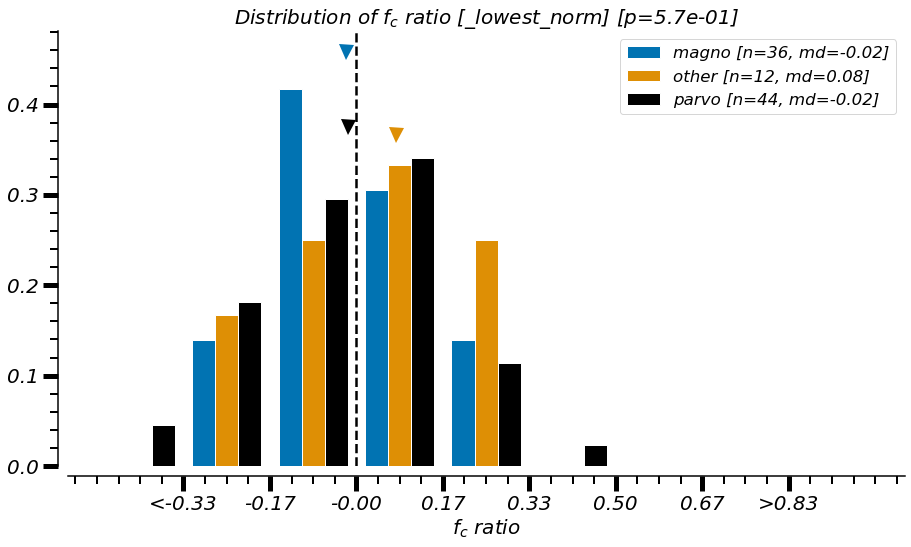

In [1091]:
fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
# fixedCon = 1; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 1; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_01_cf_rat%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    sf70bins_ratio = np.linspace(-0.5,1,10)
else:
    sf70bins_ratio = np.linspace(-1,2,10)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_cf_rats%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_cf_rats%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_cf_rats%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_cf_rats%s' % lbl]))

    
plt.xlabel(r'$f_c$ ratio');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $f_c$ ratio [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### 1.02 bandwidth across contrast (diff, as hist)

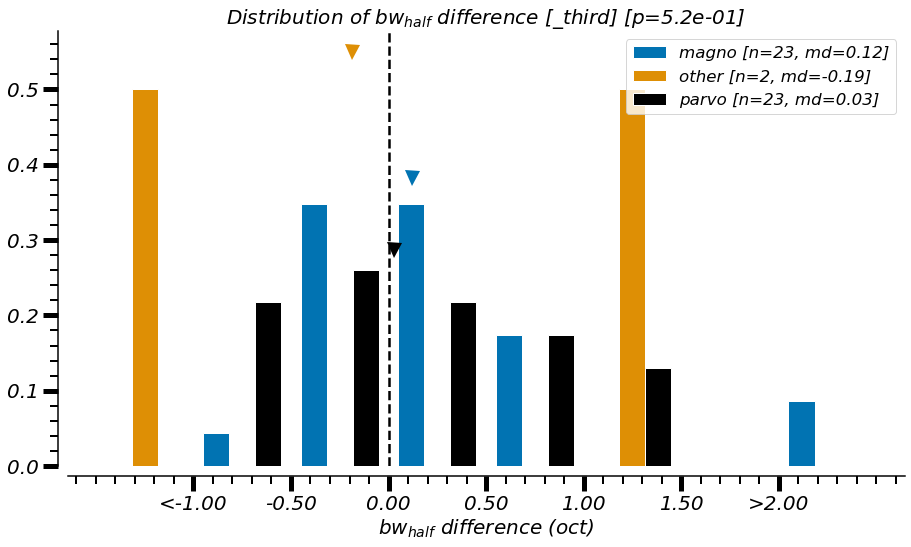

In [1092]:
fixedCon = 1; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 0; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_02_bwHalf_diff%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    bwHalfbins_ratio = np.linspace(-0.5, 0.7, 13);
else:
    bwHalfbins_ratio = np.linspace(-1.5, 2.5, 9);

plt.figure(figsize=(15, 8));

bins = bwHalfbins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_bwHalf_diffs%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    
plt.xlabel(r'$bw_{half}$ difference (oct)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $bw_{half}$ difference [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### 1.03 sf70 against sf70 across contrast

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda

Beta: [-1.86868616  1.03538179]
Beta Std Error: [0.781883   0.37067086]
Beta Covariance: [[ 0.02346371 -0.01080987]
 [-0.01080987  0.00527339]]
Residual Variance: 26.054747598950122
Inverse Condition #: 0.00021470726130018975
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-1.54285106  0.78543398]
Beta Std Error: [4.10527813e-16 3.03223460e-16]
Beta Covariance: [[ 0.16370995 -0.11830871]
 [-0.11830871  0.08931317]]
Residual Variance: 1.0294614845894843e-30
Inverse Condition #: 0.09571187771089279
Reason(s) for Halting:
  Parameter convergence
Beta: [ 0.63764996 -0.18205964]
Beta Std Error: [0.12384926 0.05291824]
Beta Covariance: [[ 0.00736976 -0.00250685]
 [-0.00250685  0.00134548]]
Residual Variance: 2.0812931033950868
Inverse Condition #: 0.22191493473993634
Reason(s) for Halting:
  Sum of squares convergence


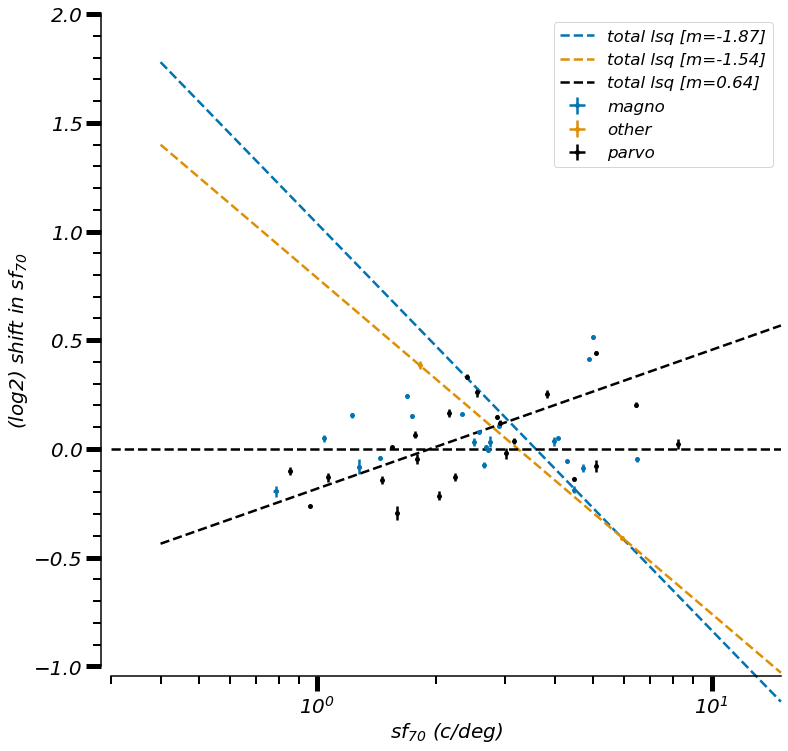

In [1093]:
fixedCon = 1; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 1; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_03_sf70_v_sf70_rats%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(12,12))

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):

    plt.errorbar(group['sf70_mn'], group['boot_sf70_rats%s' % lbl],
            xerr=0.1*group['sf70_stdLog'], yerr=0.1*group['boot_sf70_rats_std%s' % lbl], fmt='o',
                 color=clr, clip_on=False,
                 label=name, alpha=1)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['boot_sf70_rats%s' % lbl]));
    
    ### HACKY!! Manually setting any
    ky = 'sf70_stdLog'
    group[ky][group[ky]==0] = 1e-3;
    ky = 'boot_sf70_rats_std%s' % lbl
    group[ky][group[ky]==0] = 1e-3;
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], 
                              sy=group['boot_sf70_rats_std%s' % lbl][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)),
             '--', color=clr, clip_on=False, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=1);
    
    
plt.xlabel(r'$sf_{70}$ (c/deg)')
plt.ylabel(r'(log2) shift in $sf_{70}$')
    
plt.xscale('log')
plt.axhline(0, color='k', linestyle='--');
plt.xlim([3e-1, 1.5e1]);
plt.ylim([-1, 2]);
plt.legend(fontsize='small');

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 2. Shifts with contrast, refined view
Per discussion in VNL, we should try (or rather, revive) to consider the whole trajectory of sf70 (or bandwidth, or else) with contrast

### 01. Plot metric (e.g. sf70) against contrast - for all cells separately and then together

In [1094]:
import scipy.optimize as opt

In [1095]:
def fn(x, a, b):
    return b + a*x;
#     return b + np.log10(a)*np.log10(x);


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

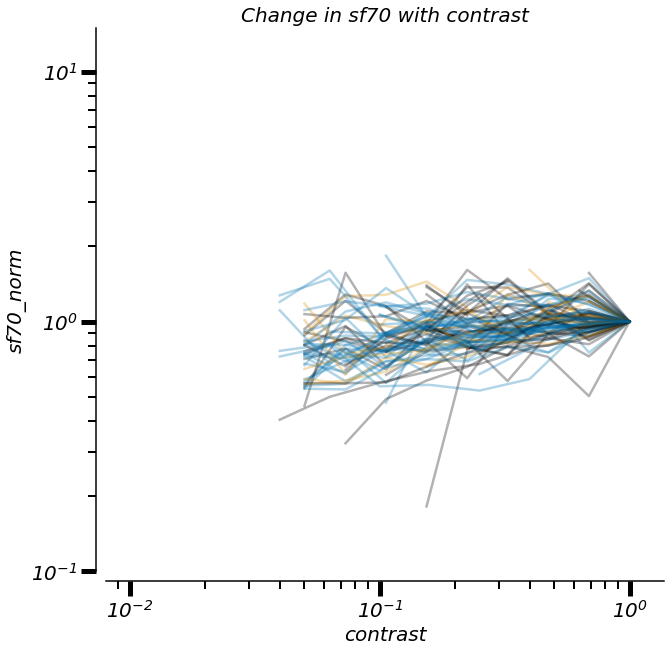

In [1099]:
metr = 'sf70'
# metr = 'charFreq'
metrIsLog = 1; # is this metric log?
var_suffix = 'stdLog' if metrIsLog else 'std';

norm = 1; # normalized?
norm_suffix = '_norm' if norm else '';

ylim = [1e-1, 1.5e1]

isDog = 1;
dog_suffix = 'dog_' if isDog else ''

# Mostly unchanged
disp = 0; # unchanged!
xlim = [1e-2, 1.1]; # contrast
low, ctr, high = 2.5, 50, 97.5; # get median, and bounds for 95% C.I.

mega_figure = plt.figure(figsize=(10,10));

# names for savig
save_loc_indiv = save_loc + '02_01_trajIndiv_%s%s/' % (dog_suffix, metr)
# -- individual name will be made within the loop
saveName = '02_01_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

reg_slopes = np.nan * np.zeros((len(mega['cellType']), 2)); # we'll store the param. and it's std.
reg_slopes_odr = np.copy(reg_slopes);

for ky in range(len(mega['cellType'])):
    
    plt.figure(figsize=(12, 12));
    
    curr_dir = mega['fullPath'][ky].split('/')[-3]
    curr_num = mega['cellNum'][ky];
    curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
    curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
    title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)

    # get which contrasts will be plotting, corresponding indices
    curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
    val_inds = mega['val_con_by_disp'][ky][disp]; # should always zero disp
    
    mtr = 'boot_%s%s_values' % (dog_suffix, metr)
           
    # then get the metric of interest
    curr_vals = mega[mtr][ky][disp, val_inds]
    curr_med, curr_low, curr_high = np.nanpercentile(curr_vals, [low, ctr, high], axis=1)
    curr_errs = [curr_low, curr_high] - curr_med

    # -- get the right color
    clr = colors[grp_names.index(curr_type)];
    
    # and plot!
    plt.scatter(curr_cons[val_inds], curr_med, color=clr, clip_on=False);
    plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False);
    # -- with linear regression (on log-log, assuming both dims are log)
    ok_for_reg = np.where(~np.isnan(curr_med))[0];
    if len(ok_for_reg) > 1:
        mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        curr_var = mega[mtr_var][ky][disp, val_inds]

        fine = opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_med[ok_for_reg]), 
                             sigma=curr_var[ok_for_reg])
        pmz = fine[0];
        perr = np.sqrt(np.diag(fine[1])); # per https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        conz = np.geomspace(curr_cons[val_inds][ok_for_reg][0], curr_cons[val_inds][ok_for_reg][-1], 50);
        reg_slopes[ky] = [pmz[0], perr[0]];
        plt.plot(conz, np.power(10, fn(np.log10(conz), *pmz)), 'k--', label=r'$m=%.2f \pm %.2f$' % (pmz[0], perr[0]))
        
        # and also do ODR?       
#         mydata = odrpack.Data(x=np.log10(curr_cons[val_inds][ok_for_reg]), 
#                                   y=np.log10(curr_med[ok_for_reg]), wd=None, we=curr_var[ok_for_reg])
        mydata = odrpack.RealData(x=np.log10(curr_cons[val_inds][ok_for_reg]), 
                                  y=np.log10(curr_med[ok_for_reg]), sx=None, sy=curr_var[ok_for_reg])
        myodr = odrpack.ODR(mydata, linear, beta0=pmz, iprint=2)
        myoutput = myodr.run()
        pmz_odr = myoutput.beta
        reg_slopes_odr[ky] = [pmz_odr[0], myoutput.sd_beta[0]]
#         plt.plot(conz, np.power(10, fn(np.log10(conz), *pmz_odr)), 'k:', label=r'$m_{odr}=%.2f$' % (pmz_odr[0]))
    
    # adjust figure
    plt.xscale('log');
    plt.xlabel('contrast');
    if metrIsLog:
        plt.yscale('log');
        plt.axis('equal');
    plt.ylim(ylim);
    plt.xlim(xlim);
    plt.ylabel('%s' % metr);

    plt.legend(fontsize='x-small')
    
    plt.title('%s' % title);
    sns.despine(offset=10);
    
    # Save the current one
    saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
    if not os.path.exists(save_loc_indiv):
        os.makedirs(save_loc_indiv)
    pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
    f = plt.gcf();
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    plt.clf(); # close the plot
    
    # replot on the first one, too
    plt.figure(1);
    if norm:
        try:
            # normalize by the metric value at the highest valid contrast
            norm_ind = np.where(~np.isnan(curr_med))[0][-1];
            curr_med_norm = np.divide(curr_med, curr_med[norm_ind])
            plt.plot(curr_cons[val_inds], curr_med_norm, color=clr, clip_on=False, alpha=0.3)
#             plt.errorbar(curr_cons[val_inds], curr_med_norm, curr_errs, color=clr, clip_on=False, alpha=0.3)
        except:
            pass
    else:
        plt.plot(curr_cons[val_inds], curr_med, color=clr, clip_on=False, alpha=0.3)
#         plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False, alpha=0.3)

# at the end, fix up the overall figure
plt.figure(1);

plt.xscale('log');
plt.xlabel('contrast')
if metrIsLog:
    plt.yscale('log')
    plt.axis('equal')
plt.ylim(ylim);
plt.xlim(xlim);
plt.ylabel('%s%s' % (metr, norm_suffix))
plt.title('Change in %s with contrast' % metr)

sns.despine(offset=10)

# Save the overall plot
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()
# plt.clf() # close the plot


# And save the slopes in the overall structure
mega['conSlope_%s%s' % (dog_suffix, metr)] = reg_slopes[:,0]
mega['conSlope_%s%s_odr' % (dog_suffix, metr)] = reg_slopes_odr[:,0]
mega['conSlope_%s%s_std' % (dog_suffix, metr)] = reg_slopes[:,1]

##### Alternative version which uses mean + std (as opposed to confidence intervals)

In [1100]:
# metr = 'sf70'
# metrIsLog = 1; # is this metric log?
# var_suffix = 'stdLog' if metrIsLog else 'std';

# norm = 0; # normalized?
# norm_suffix = '_norm' if norm else '';

# ylim = [0.25, 4] if norm else [1e-1, 1.5e1]

# isDog = 1;
# dog_suffix = 'dog_' if isDog else ''

# # Mostly unchanged
# disp = 0; # unchanged!
# xlim = [1e-2, 1.1]; # contrast

# mega_figure = plt.figure(figsize=(10,10));

# errMult = 1.96; # 1.96 _should_ be 95% CI; otherwise, just use 1

# # names for savig
# save_loc_indiv = save_loc + '02_01alt_trajIndiv_%s%s/' % (dog_suffix, metr)
# # -- individual name will be made within the loop
# saveName = '02_01alt_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

# for ky in range(len(mega['cellType'])):
    
#     plt.figure(figsize=(10, 10));
    
#     curr_dir = mega['fullPath'][ky].split('/')[-3]
#     curr_num = mega['cellNum'][ky];
#     curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
#     curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
#     title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)

#     # get which contrasts will be plotting, corresponding indices
#     curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
#     val_inds = mega['val_con_by_disp'][ky][disp]; # should always zero disp
    
#     mtr_mn = 'boot_%s%s_mn' % (dog_suffix, metr)
    
#     mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        
#     # then get the metric of interest
#     curr_vals = mega[mtr_mn][ky][disp, val_inds];
#     curr_errs = mega[mtr_var][ky][disp, val_inds];
    
#     clr = colors[grp_names.index(curr_type)];
    
#     plt.scatter(curr_cons[val_inds], curr_vals, color=clr, clip_on=False);
#     plt.errorbar(curr_cons[val_inds], curr_vals, errMult*curr_errs, color=clr, clip_on=False);
        
#     plt.xscale('log');
#     plt.xlabel('contrast');
#     if metrIsLog:
#         plt.yscale('log');
#         plt.axis('equal');
#     plt.ylim(ylim);
#     plt.xlim(xlim);
#     plt.ylabel('%s' % metr);

#     plt.title('%s' % title);
#     sns.despine(offset=5);
    
#     # Save the current one
#     saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
#     if not os.path.exists(save_loc_indiv):
#         os.makedirs(save_loc_indiv);
#     pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
#     f = plt.gcf();
#     pdfSv.savefig(f); # only one figure here...
#     pdfSv.close();
#     plt.clf(); # close the plot
    
#     # replot on the first one, too
#     plt.figure(1);
#     if norm:
#         try:
#             # normalize by the metric value at the highest valid contrast
#             norm_ind = np.where(~np.isnan(curr_vals))[0][-1];
#             curr_vals_norm = np.divide(curr_vals, curr_vals[norm_ind])
#             plt.plot(curr_cons[val_inds], curr_vals_norm, color=clr, clip_on=False, alpha=0.3);
#         except:
#             pass
#     else:
#         plt.plot(curr_cons[val_inds], curr_vals, color=clr, clip_on=False, alpha=0.3);

# # at the end, fix up the overall figure
# plt.figure(1);

# plt.xscale('log');
# plt.xlabel('contrast');
# if metrIsLog:
#     plt.yscale('log');
#     plt.axis('equal');
# plt.ylim(ylim);
# plt.xlim(xlim);
# plt.ylabel('%s%s' % (metr, norm_suffix));
# plt.title('Change in %s with contrast' % metr);

# sns.despine(offset=5);

# # Save the overall plot
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc);
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# f = plt.gcf();
# pdfSv.savefig(f); # only one figure here...
# pdfSv.close();
# # plt.clf() # close the plot


##### Plot the regression slopes we fit above

In [1119]:
gns = [mega['dog_mech'][x][0,-1,0] for x in range(len(mega))]
mx = [mega['mn_med_max'][x][2] for x in range(len(mega))]

In [1126]:
pms = mega['dog_mech'][60][0,-1]

In [1130]:
mega['mn_med_max'][60]

array([ 89.12444444,  70.4       , 191.2       ])

In [1139]:
r_c = 0.02
const = 200/(r_c*np.sqrt(np.pi))
print(const)

5641.895835477563


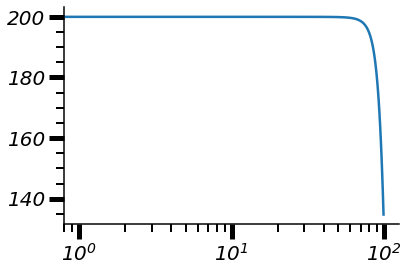

In [1140]:
f = np.geomspace(0.01, 10, 100);
plt.semilogx(const * np.sqrt(np.pi) * r_c * np.exp(-np.square(f*np.pi*r_c)))

In [1132]:
pms[0]*pms[1]*np.sqrt(np.pi)

484.9564505600818

In [1129]:
pms[0]

600.9714570046874

In [1102]:
jointList[0]['metrics'].keys()

dict_keys(['sfVar', 'sfCom', 'boot_sfCom_mn', 'boot_sfCom_md', 'boot_sfCom_std', 'boot_sfCom_stdLog', 'sfComCut', 'bw_sigma', 'lsfv', 'bwHalf', 'boot_bwHalf_mn', 'boot_bwHalf_md', 'boot_bwHalf_std', 'boot_bwHalf_stdLog', 'dog_bwHalf', 'boot_dog_bwHalf_mn', 'boot_dog_bwHalf_md', 'boot_dog_bwHalf_std', 'boot_dog_bwHalf_stdLog', 'bw34', 'boot_bw34_mn', 'boot_bw34_md', 'boot_bw34_std', 'boot_bw34_stdLog', 'dog_bw34', 'boot_dog_bw34_mn', 'boot_dog_bw34_md', 'boot_dog_bw34_std', 'boot_dog_bw34_stdLog', 'pSf', 'boot_pSf_mn', 'boot_pSf_md', 'boot_pSf_std', 'boot_pSf_stdLog', 'dog_pSf', 'boot_dog_pSf_mn', 'boot_dog_pSf_md', 'boot_dog_pSf_std', 'boot_dog_pSf_stdLog', 'sf70', 'boot_sf70_mn', 'boot_sf70_md', 'boot_sf70_std', 'boot_sf70_stdLog', 'dog_sf70', 'boot_dog_sf70_mn', 'boot_dog_sf70_md', 'boot_dog_sf70_std', 'boot_dog_sf70_stdLog', 'dog_charFreq', 'boot_dog_charFreq_mn', 'boot_dog_charFreq_md', 'boot_dog_charFreq_std', 'boot_dog_charFreq_stdLog', 'sfE', 'dog_sfE', 'sfVarExpl', 'dog_varExpl

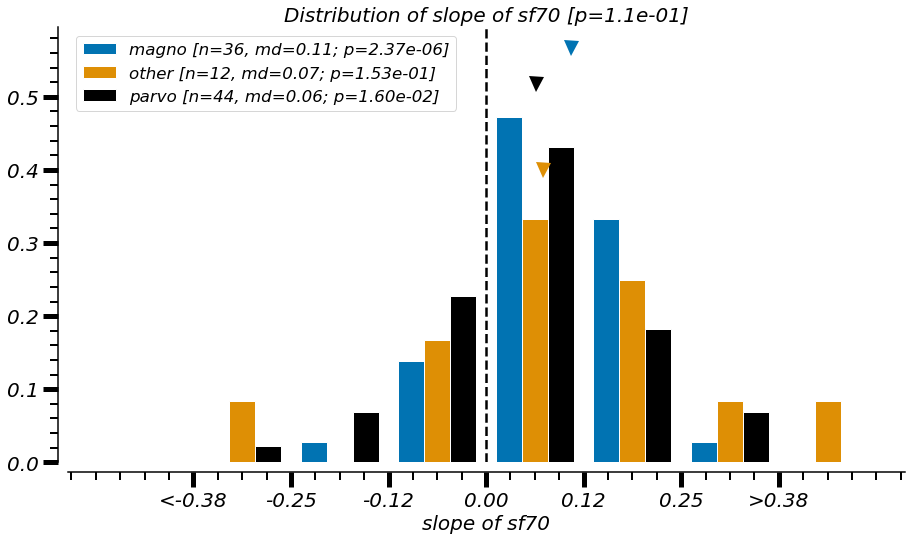

In [1101]:
odrSlopes = 0; # 1 if odr, 0 of least squares
odr_suffix = '_odr' if odrSlopes else ''

saveName = '02_01_%s%s_slopes%s.pdf' % (dog_suffix, metr, odr_suffix)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = np.linspace(-0.5, 0.5, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
    vals_no_nan = hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)])
    
    clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(vals_no_nan);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f; p=%.2e]' % (name, np.sum(vals), mdn, pval_curr.pvalue), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
        
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)]))
    else:
        to_comp.append(hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)]))
    
# unity/no effect line
plt.axvline(no_effect, color='k', linestyle='--')

plt.xlabel(r'slope of %s' % metr);
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of slope of %s [p=%.1e]' % (metr, ttest.pvalue))
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 02. Scatter plots!

#### 02.02a sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

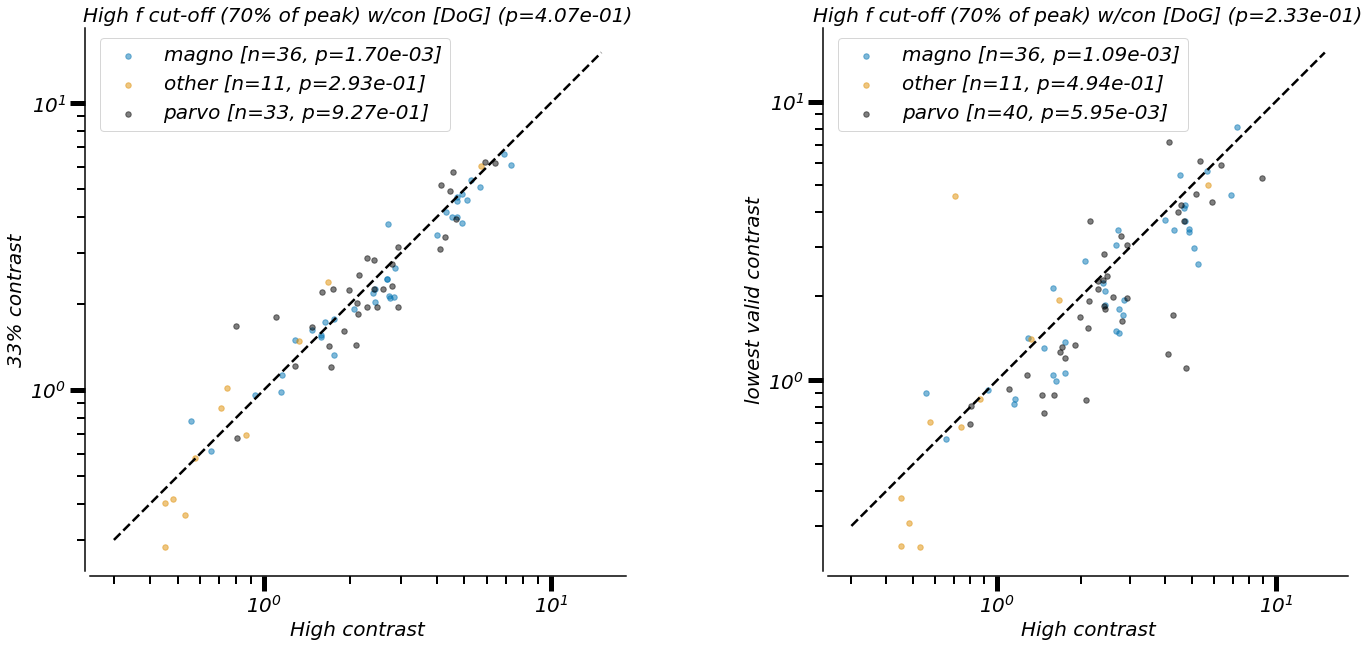

In [961]:
whichFit = 1; # 0 for non-DoG, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''
normCon = 0; # normalize by the contrast ratio ()

# are we getting the values from the bootstrap estimates or no?
bootEst = 0;
bootStr= '_boot' if bootEst else '';

normStr = '_norm' if normCon else ''

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

saveName = '02_02a_sf70_%sscatter_%s%s%s.pdf' % (prefix, fitBase, exclStr, bootStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

# Likely unchanged...
low, ctr, high = 25, 50, 75; # get median, and bounds for X% C.I. (e.g. 95%)
disp=0 
yLabels = ['33% contrast', 'lowest valid contrast']
alphScatter = 0.5

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    
    to_comp = [];
    
    ### Gather the data, put into "mega"
    if bootEst:
        highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % prefix, whichFit, i)
        highSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in highSf])
        compSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in compSf])

        if i == 0:
            mega['%ssf70_high' % prefix] = highSplits[:,0];
            mega['%ssf70_high_CI_lo' % prefix] = highSplits[:,1];
            mega['%ssf70_high_CI_hi' % prefix] = highSplits[:,2];
            mega['%ssf70_third' % prefix] = compSplits[:,0];
            mega['%ssf70_third_CI_lo' % prefix] = compSplits[:,1];
            mega['%ssf70_third_CI_hi' % prefix] = compSplits[:,2];
            mega['%ssf70_cons_third' % prefix] = compCons;
        elif i == 1:
            mega['%ssf70_low' % prefix] = compSplits[:,0];
            mega['%ssf70_low_CI_lo' % prefix] = compSplits[:,1];
            mega['%ssf70_low_CI_hi' % prefix] = compSplits[:,2];
            mega['%ssf70_cons_low' % prefix] = compCons;
        
    else:
        highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, i)
        if i == 0:
            mega['%ssf70_high' % prefix] = highSf;
            mega['%ssf70_third' % prefix] = compSf;
            mega['%ssf70_cons_third' % prefix] = compCons           
        elif i == 1:
            mega['%ssf70_low' % prefix] = compSf;
            mega['%ssf70_cons_low' % prefix] = compCons

    # and add ratio
    highSfs = mega['%ssf70_high' % prefix]
    divFactor = np.log2(np.divide(1, compCons)) if normCon else 1;
    if i == 0:
        mega['%ssf70_ratio_third%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_third' % prefix])) / divFactor
    elif i == 1:
        mega['%ssf70_ratio_low%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_low' % prefix])) / divFactor

            
    ### Go through by group to plot
    grouped = mega.groupby(toGroup)
    
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
        compCons = group['%ssf70_cons_third' % prefix] if i == 0 else group['%ssf70_cons_low' % prefix];
        if excludeOneThirds and i == 1:
            validInds = compCons<0.3 #np.where(compCons<0.3)[0];
        else:
            validInds = compCons<0.4 #np.where(compCons<0.4)[0]; # should be at least <40% contrast!

        highSf = group['%ssf70_high' % (prefix)]
        compSf = group['%ssf70_third' % (prefix)] if i==0 else group['%ssf70_low' % prefix]
            
        if bootEst:
            hi_errLow = group['%ssf70_high_CI_lo' % prefix] if i == 0 else group['%ssf70_high_CI_lo' % prefix]
            hi_errHigh = group['%ssf70_high_CI_hi' % prefix] if i == 0 else group['%ssf70_high_CI_hi' % prefix]
            comp_errLow = group['%ssf70_third_CI_lo' % prefix] if i == 0 else group['%ssf70_low_CI_lo' % prefix]
            comp_errHigh = group['%ssf70_third_CI_hi' % prefix] if i == 0 else group['%ssf70_low_CI_hi' % prefix]
            
        non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
        val_inds = np.logical_and(non_nan, validInds)
        
        rats_curr = np.divide(highSf[val_inds], compSf[val_inds]);
        if normCon:
            conRat_log2 = np.log2(np.divide(1, compCons[val_inds]))
            rats_curr = np.divide(rats_curr, conRat_log2);

        paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
        pval = paired_t.pvalue;
        
        if bootEst: # then we include C.I.!
            ax[i].errorbar(highSf[val_inds], compSf[val_inds], 
                           xerr=[hi_errLow[val_inds] - highSf[val_inds], highSf[val_inds] - hi_errHigh[val_inds]],
                           yerr=[comp_errLow[val_inds] - compSf[val_inds], compSf[val_inds] - comp_errHigh[val_inds]],
                           label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval), 
                           alpha=alphScatter, color=clr, fmt='o')#, s=30)
        else:
            ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=alphScatter, color=clr, 
                          s=30, label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval))
            
        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(rats_curr)
        else:
            to_comp.append(rats_curr)

    # after plotting each group, set the visuals        
    ax[i].loglog([0.3,15], [0.3, 15], 'k--')
    paired_t = ss.ttest_ind(to_comp[0], to_comp[1])
    pval = paired_t.pvalue;
    ax[i].set_title('High f cut-off (70%% of peak) w/con %s(p=%.2e)' % (suffix, pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].set_aspect('equal')
    ax[i].legend()
    
sns.despine(offset=5)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

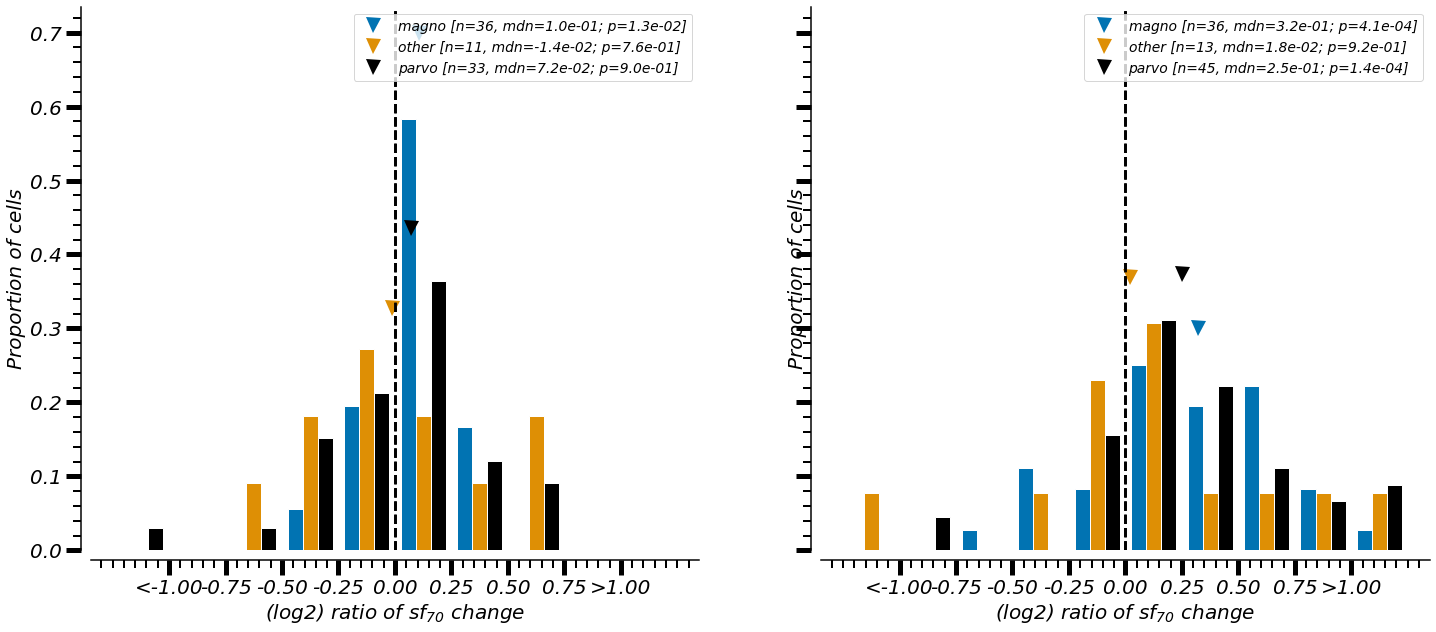

In [962]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist%s' % normStr)

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

if normCon:
    bins = np.linspace(-0.5, 0.5, 9);
else:
    bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

normStr = ', con. norm' if normCon==1 else '';

xlabs = ['1:0.33', '1:lowestCon']

grouped = mega.groupby(toGroup)

no_effect = 0;

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_all):

    #########################
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
        key_str = '%ssf70_ratio_third%s' % (prefix, bootStr) if i == 0 else '%ssf70_ratio_low%s' % (prefix, bootStr)
        vals_no_nan = hf.nan_rm(group[key_str]); # log transform the ratios s.t. 0 means no shift

        ratsClipped = np.clip(vals_no_nan, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
        vals, _ = np.histogram(ratsClipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        # compute mean/median, pvalue (i.e. are ratios diff. from 0)
        mn, mdn = np.nanmean(vals_no_nan), np.nanmedian(vals_no_nan);
        pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
       
        
        # plot the median, add label
        ax[i].plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15, 
                   label='%s [n=%02d, mdn=%.1e; p=%.1e]' % (name, len(ratsClipped), mdn,  pval_curr.pvalue))

        # plot the histogram
        ax[i].bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
                alpha=alphHist);
        
        # do the ticks
        tickStrs = ['%.2f' % x for x in tickVals];
#         tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
        tickStrs[0] = '<%s' % tickStrs[0];
        tickStrs[-1] = '>%s' % tickStrs[-1];
        ax[i].set_xticks(tickVals);
        ax[i].set_xticklabels(tickStrs)
        
        # add a no-effect line, legend, axis labels, etc
        ax[i].axvline(0, linestyle='--', color='k')
        ax[i].legend(fontsize='x-small');
        ax[i].set_xlabel(r'(log2%s) ratio of $sf_{70}$ change' % normStr)
        ax[i].set_ylabel('Proportion of cells');
        
        
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 3. Mechanism (with DoG analysis)

#### Let's get the radius, gain, volume for the center and surround mechanisms

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:158: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Adding an axes using the s

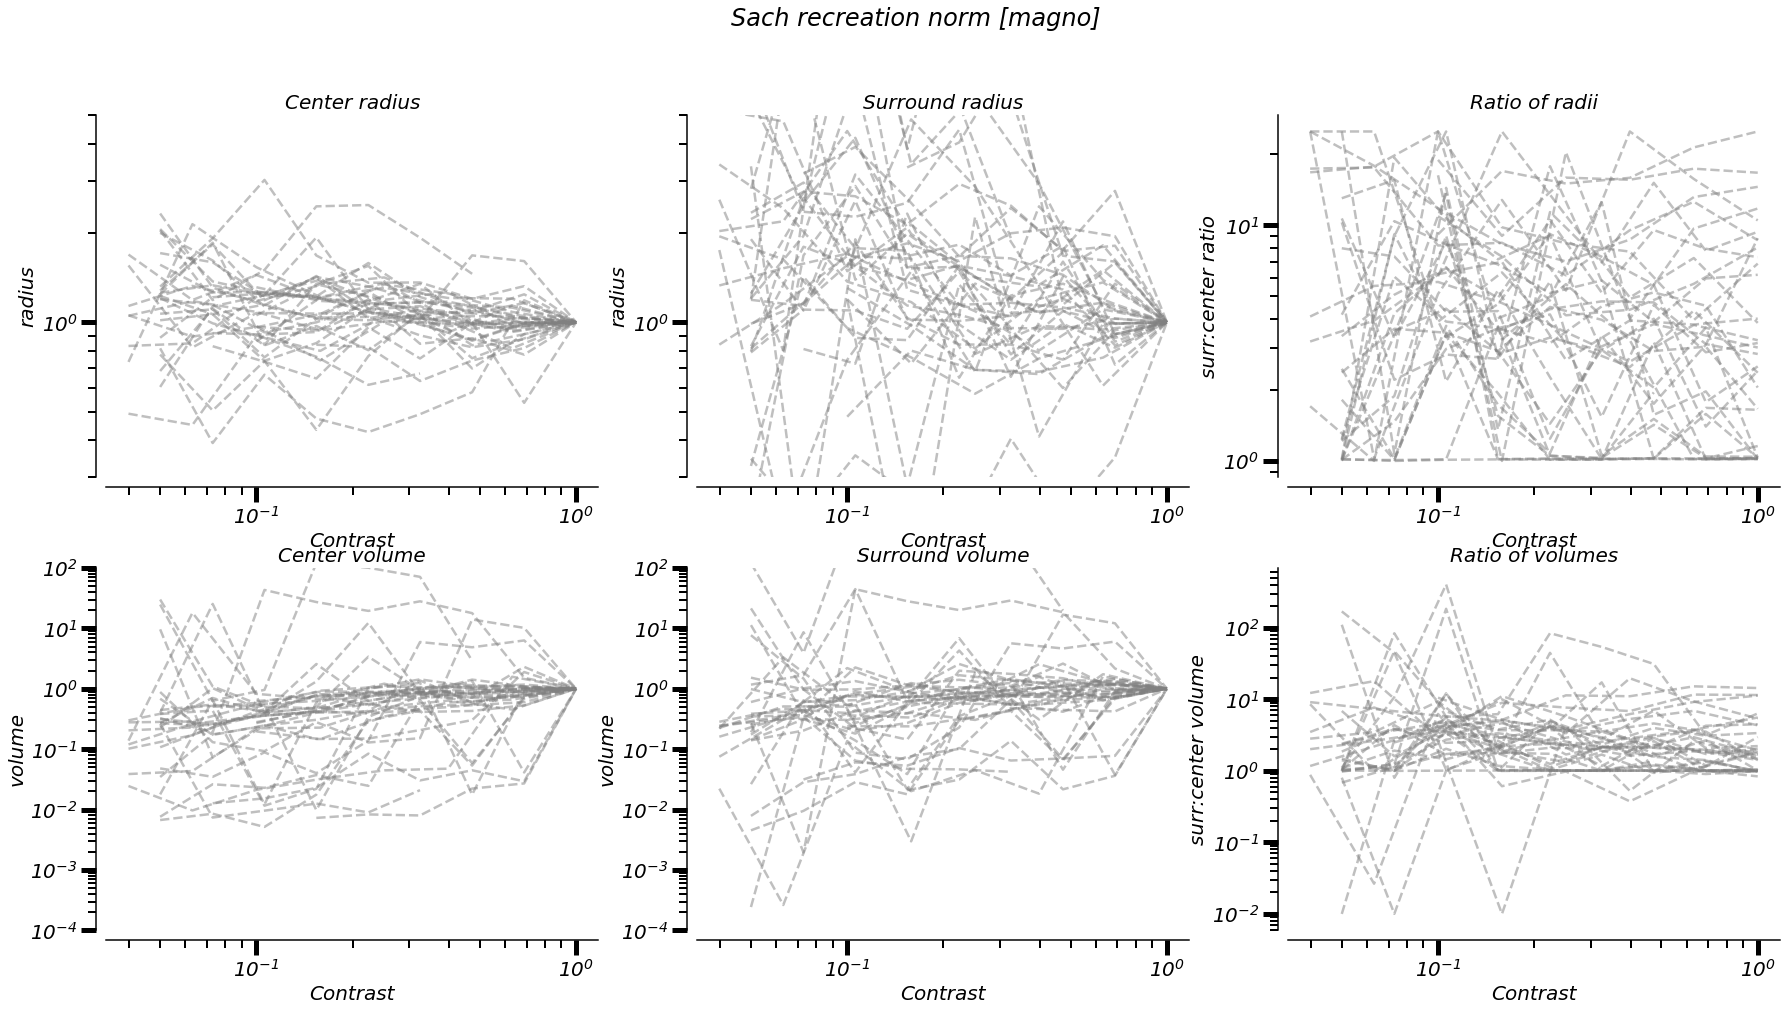

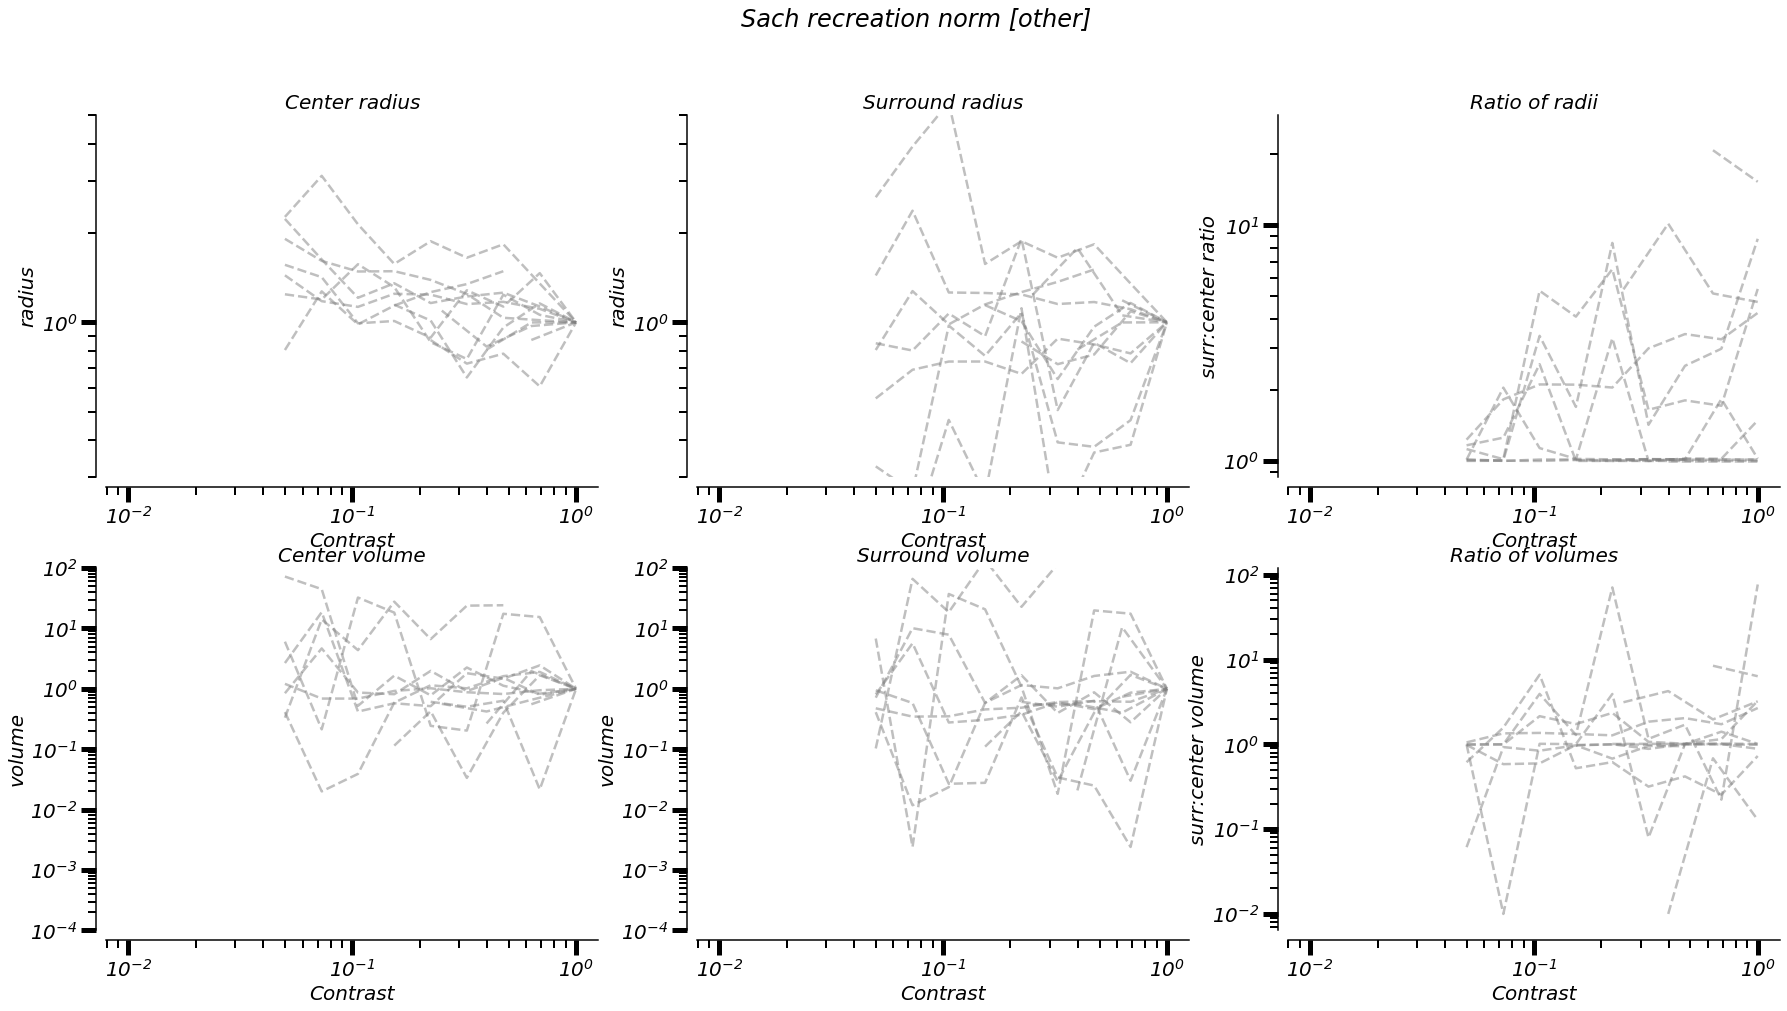

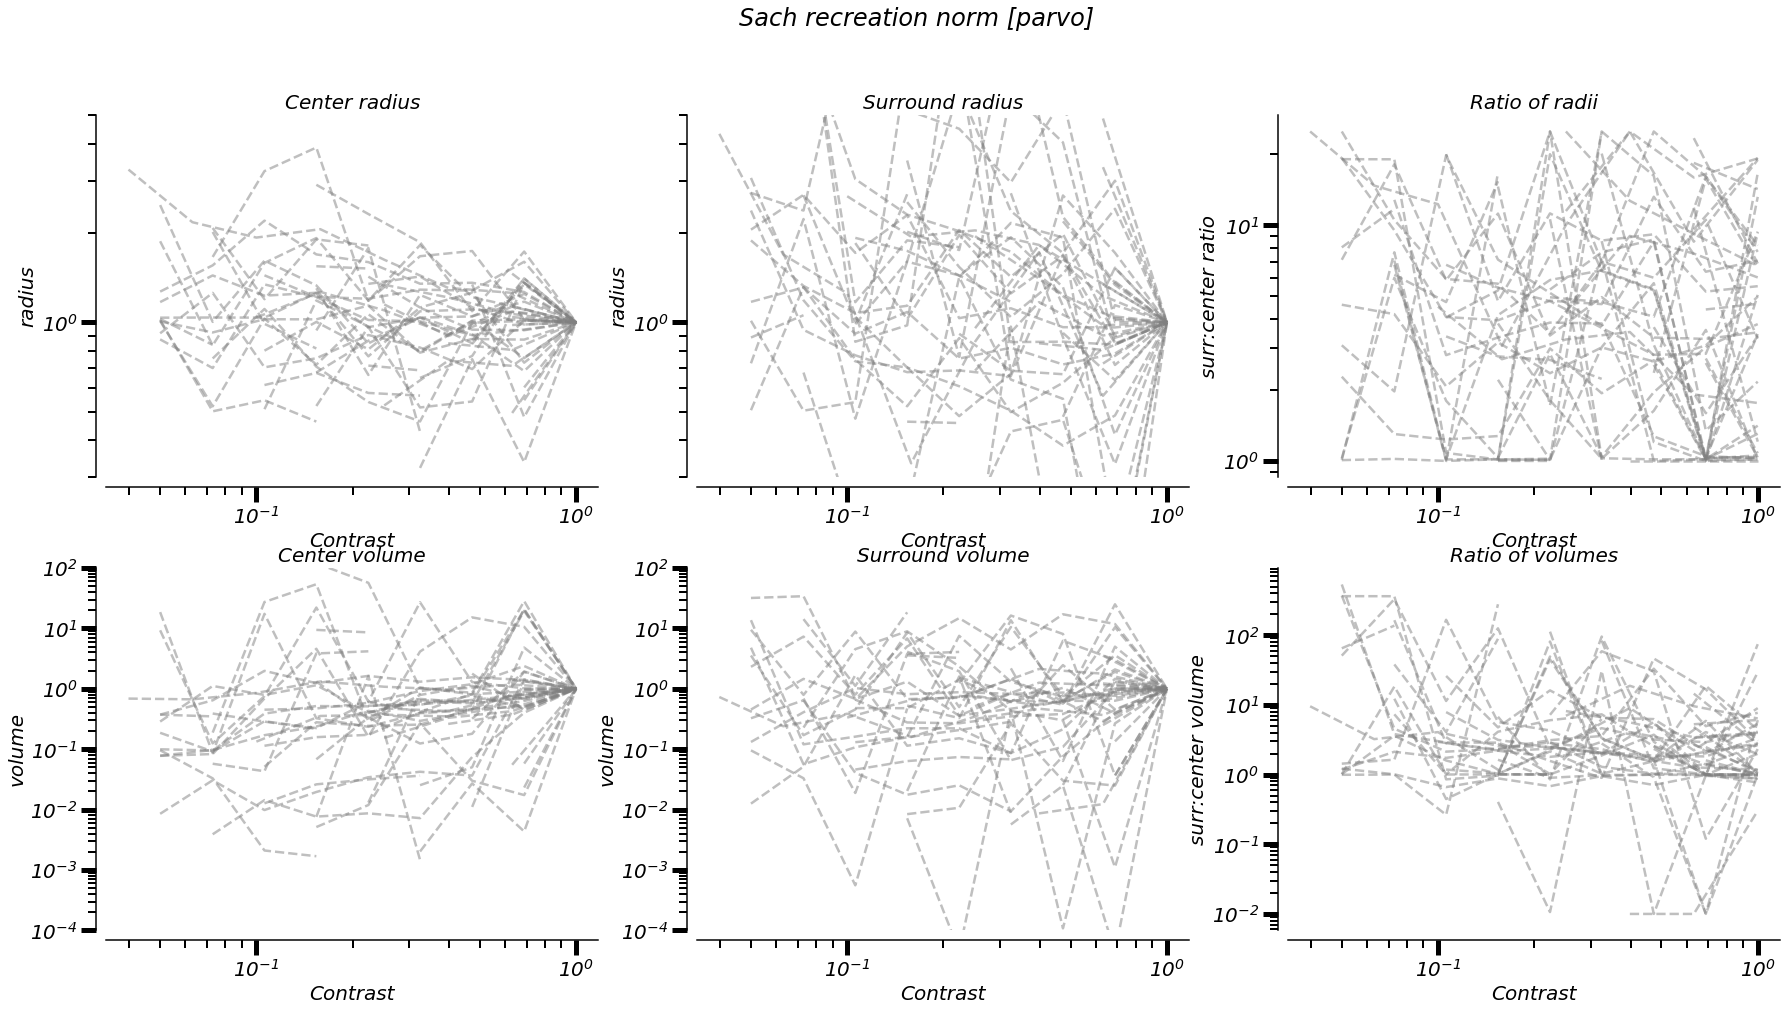

In [1061]:
grouped = mega.groupby(toGroup)

boot = 0;
bootStr = 'boot ' if boot else ' ';

disp = 0;
norm = 1;
normStr = 'norm ' if norm else ' ';

# indices into ['dog_mech']
i_gc, i_rc, i_vc, i_gs, i_rs, i_vs = range(6);
mdn = 50; # we want 50th percentile

for (name, group), clr, widOffset in zip(grouped, colors, offsets):

    f, ax = plt.subplots(2, 3, figsize=(30, 15))

    # do the visuals, axes, labels, etc
    gray = cm.gray(0.5) # mean gray
    f.suptitle('Sach recreation %s[%s]' % (normStr, name))
    f.subplots_adjust(wspace=0.2, hspace=0.25);

    # center radius
    plt.subplot(2, 3, 1);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 1]);
    plt.xlabel('Contrast');
    plt.ylabel('radius')
    plt.title('Center radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround radius
    plt.subplot(2, 3, 2);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('radius')
    plt.title('Surround radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround radius
    plt.subplot(2, 3, 3);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center ratio')
    plt.title('Ratio of radii')
    plt.xscale('log')
    plt.yscale('log')
    
    # center volume
    plt.subplot(2, 3, 4);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Center volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround volume
    plt.subplot(2, 3, 5);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Surround volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround volume
    plt.subplot(2, 3, 6);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center volume')
    plt.title('Ratio of volumes')
    plt.xscale('log')
    plt.yscale('log')
    
    for ky in group['cellType'].index:
        
        # Go through each cell in this group
        curr_dir = group['fullPath'][ky].split('/')[-3]
        curr_num = group['cellNum'][ky];
        curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
        
        # -- get the contrasts that are used
        curr_inds = group['val_con_by_disp'][ky][disp]; # zero dispersion, always?
        curr_cons = group['stimVals'][ky][1][curr_inds]
        
        # center radius
        plt.subplot(2, 3, 1);
        if boot:
            curr_rc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rc, :], mdn, axis=1)
        else:
            curr_rc = group['dog_mech'][ky][disp, curr_inds, i_rc]
        non_nan = np.where(~np.isnan(curr_rc))[0]
        if len(non_nan) > 1:
            curr_rc_plt = np.divide(curr_rc, curr_rc[non_nan[-1]]) if norm else curr_rc;
            plt.plot(curr_cons, curr_rc_plt, '--', color=gray, alpha=0.5)

        # surround radius
        plt.subplot(2, 3, 2);
        if boot:
            curr_rs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rs, :], mdn, axis=1)
        else:
            curr_rs = group['dog_mech'][ky][disp, curr_inds, i_rs]
        non_nan = np.where(~np.isnan(curr_rs))[0]
        if len(non_nan) > 1:
            curr_rs_plt = np.divide(curr_rs, curr_rs[non_nan[-1]]) if norm else curr_rs;
            plt.plot(curr_cons, curr_rs_plt, '--', color=gray, alpha=0.5)
            
        # center:surr radii
        plt.subplot(2, 3, 3);
        curr_rats = np.divide(curr_rs, curr_rc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

        # center volume
        plt.subplot(2, 3, 4);
        if boot:
            curr_vc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vc, :], mdn, axis=1)
        else:
            curr_vc = group['dog_mech'][ky][disp, curr_inds, i_vc]
        non_nan = np.where(~np.isnan(curr_vc))[0]
        if len(non_nan) > 1:
            curr_vc_plt = np.divide(curr_vc, curr_vc[non_nan[-1]]) if norm else curr_vc;
            plt.plot(curr_cons, curr_vc_plt, '--', color=gray, alpha=0.5)

        # surround volume
        plt.subplot(2, 3, 5);
        if boot:
            curr_vs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vs, :], mdn, axis=1)
        else:
            curr_vs = group['dog_mech'][ky][disp, curr_inds, i_vs]
        non_nan = np.where(~np.isnan(curr_vs))[0]
        if len(non_nan) > 1:
            curr_vs_plt = np.divide(curr_vs, curr_vs[non_nan[-1]]) if norm else curr_vs;
            plt.plot(curr_cons, curr_vs_plt, '--', color=gray, alpha=0.5)

        # volume ratio
        plt.subplot(2, 3, 6);
        curr_rats = np.divide(curr_vs, curr_vc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

    # then after all cells, save
    sns.despine(offset=10)
    
    saveName = "/03_01_sach_%s%s%s.pdf" % (normStr.replace(' ', '_'), bootStr.replace(' ', '_'), name)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

# END OF UPDATED ANALYSES

#### 02.02b Preferred spatial frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

In [ ]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

saveName = '02_02b_sfPref_%sscatter_%s%s.pdf' % (prefix, fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

rats_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):

    highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
       
    rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
        
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Preferred SF with contrast %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].set_aspect('equal')
    
sns.despine(offset=5)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('Preferred SF with contrast %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()